# Using graphs and majorana operations to do fermionic to qubit mapping

#### Team: Filip-Ioan Ceară, Cristian Ilie, Thierry Kaldenbach, Marc Maußner, Oneka Singh

## Introduction

In quantum chemistry running VQE/ADAPT-VQE with the use of UCCSD (unified-coupled-cluster with single and double excitations) is the "golden standard" for calculating the groundstate of an molecule hamiltonian. 
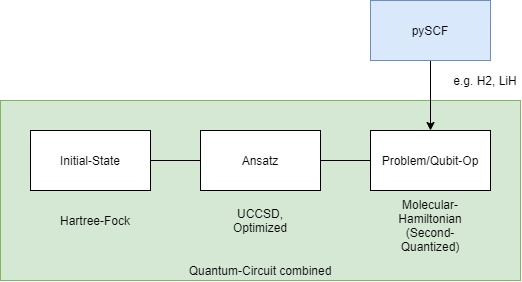

When using Jordan-Wigner for mapping from fermionic space to qubit space, we face a Complexity of O(n) (Linear in the number of qubits).
This can be improved by using other mappers, like ParityMapping or Bravi-Kitaev [SRL12] leading to a complexity of O(log(n)).

After combination of initial state, ansatz and molecule hamiltonian (qubit_op, almost in second-quantization form), we need to transpile the circuit to the underlying hardware to be able to run VQE and/or ADAPT-VQE and obtain the ground states. 

__Limitations:__ 
- UCCSD taking all single and double excitations - that usually are not used when facing molecules in real nature - brings an overhead in number of operations/gates used as ansatz.
- The mapping from fermions to qubits might also not be optimal, because of the generality of its uses.

## Idea

Our main focus lies on the optimization of the fermionic to qubit mapping. In the first stage we try to do this hardware agnostic and use the Majorana operations as shown in [MGZ24] formula (6):
- "Normal" hamiltonian:
$$
  H_{f} =  \sum \limits _{ij} ^{N-1}h_{ij}{a_{i}^\dagger}a_{j} + \sum \limits _{ijkl}{a_{i}^\dagger}{a_{j}^\dagger}a_{k}a_{l}
$$
- Majorana hamiltonian:
$$
  H_{f} =  \sum \limits _{ij} ^{2N-1}ic_{ij}m_{i}m_{j} + \sum \limits _{ijkl} ^{2N-1}c_{ijkl}m_{i}m_{j}m_{k}m_{l}
$$
In optimizing the depth (= number of qubits used in average throughout our Pauli-Strings), we try to reduce the SWAP gates lateron added/used by transpiler.
In optimizing the depth including the gate errors, we try to reduce not only the SWAP gates but also the error rates before even tranpiling.

In a further stage we will implement the mapping taking also the coupling map and error-rates (single qubit gates, two qubit gates, readout-error) into consideration.
The whole idea can be found in: 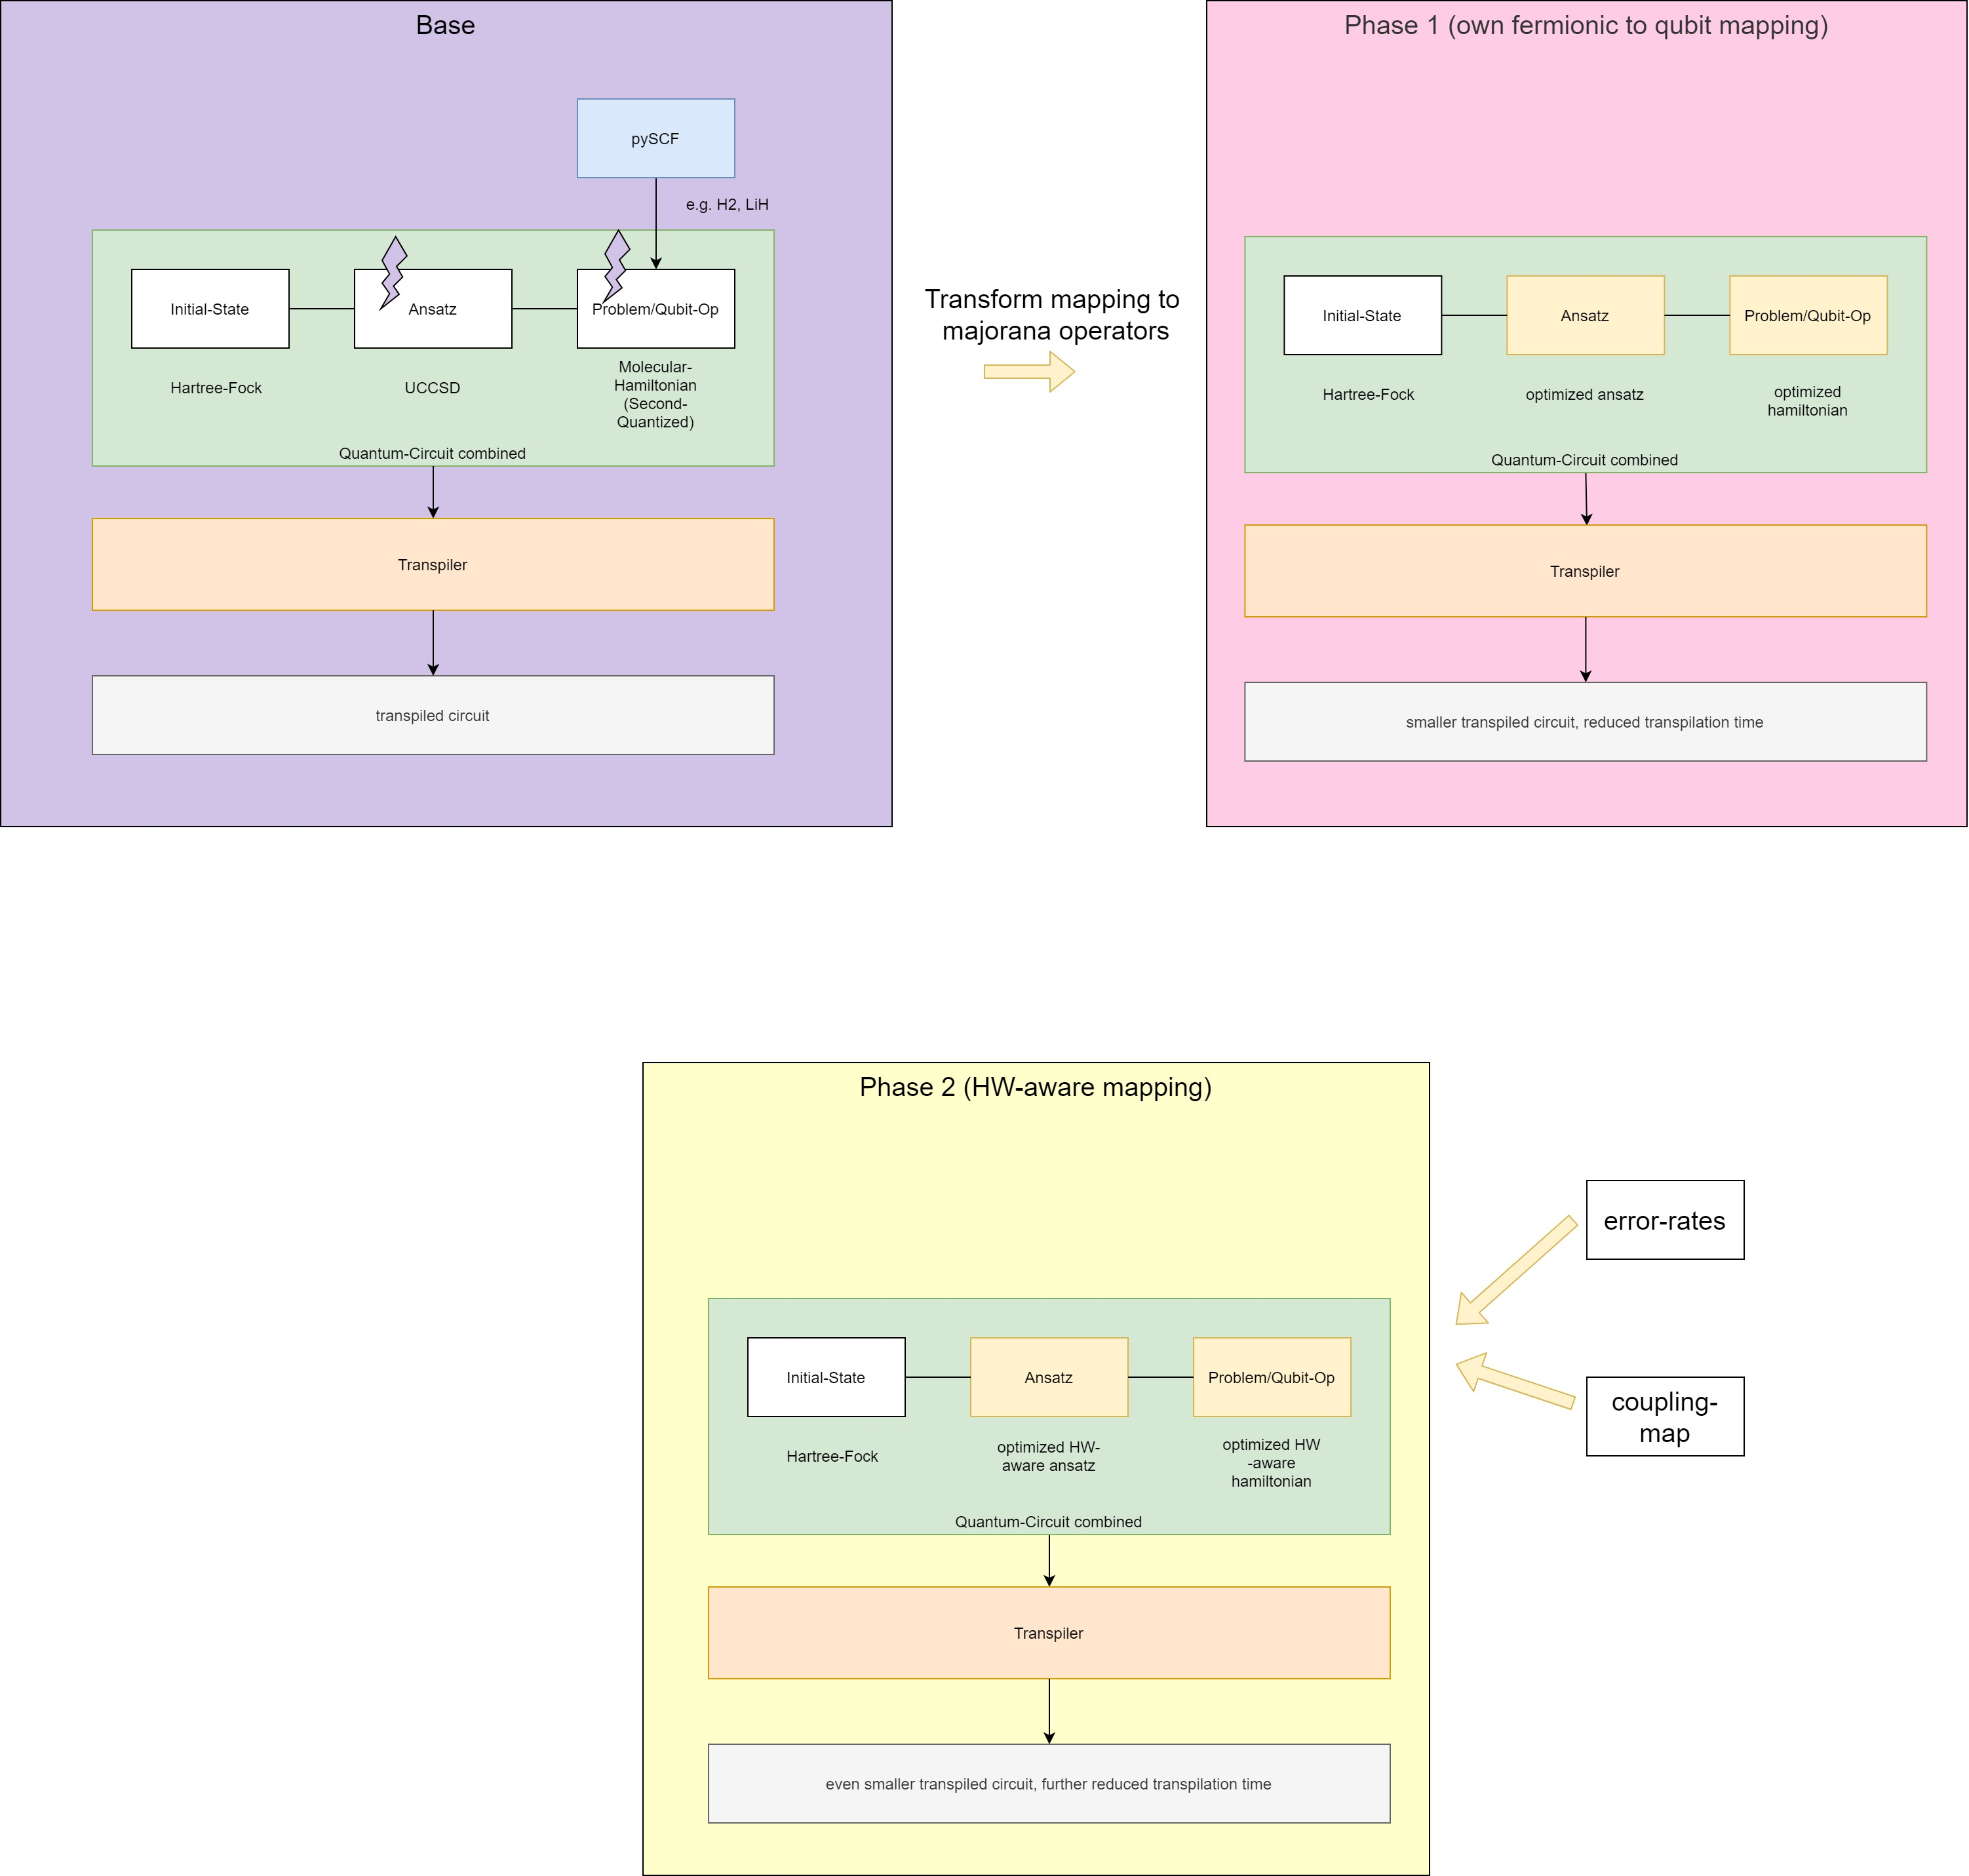

So we change used hamiltonian from a general JordanWigner-Mapping to an Majorana-Mapping and benchmark it against the UCCSD resources (count_ops, size, depth) obtained with the Bravi-Kitaev mapping.

## "Naive"/default solution and motivation for our problem

In [9]:
# imports
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

from qiskit_algorithms import AdaptVQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

Use pySCF to obtain the electronic structure problem for H2O and LiH:

In [10]:
driver_h2o = PySCFDriver(atom="O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0", basis="sto-3g")
problem_h2o = driver_h2o.run()

driver_lih = PySCFDriver(atom="Li 0 0 0; H 0 0 1.5", basis="sto-3g")
problem_lih = driver_lih.run()

In [11]:
mappers = {}
mappers["JW"] = JordanWignerMapper()
mappers["Parity"] = ParityMapper()
mappers["Bravi-Kitaev"] = BravyiKitaevMapper()

Obtain the count_ops, size and depth for a given molecule hamiltonian with UCCSD ansatz and use of different mappers:

In [12]:
def obtain_resources(problem):
    for key in mappers.keys():
        print(f"Generating ansatz and mapped qubit-op for: {key}")
        qubit_op = mappers[key].map(problem.second_q_ops()[0])
    
        ansatz = UCCSD(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mappers[key],
            initial_state=HartreeFock(
                problem.num_spatial_orbitals,
                problem.num_particles,
                mappers[key],
            ),
        )

        print(f"\tANSATZ: Count-Ops: {ansatz.decompose().decompose().decompose().count_ops()} size: {ansatz.decompose().decompose().decompose().size()} depth = {ansatz.decompose().decompose().decompose().depth()}")
        #print(f"\tqubit-op: {qubit_op}")


### Estimate resources for different mappers of UCCSD for H2O

In [13]:
obtain_resources(problem_h2o)

Generating ansatz and mapped qubit-op for: JW
	ANSATZ: Count-Ops: OrderedDict([('cx', 14360), ('h', 7840), ('sdg', 1960), ('s', 1960), ('rz', 1000), ('u', 10)]) size: 27130 depth = 18014
Generating ansatz and mapped qubit-op for: Parity
	ANSATZ: Count-Ops: OrderedDict([('cx', 14020), ('h', 12440), ('sdg', 1768), ('s', 1768), ('rz', 1000), ('u', 7)]) size: 31003 depth = 17700
Generating ansatz and mapped qubit-op for: Bravi-Kitaev
	ANSATZ: Count-Ops: OrderedDict([('cx', 13108), ('h', 11122), ('sdg', 2889), ('s', 2889), ('rz', 999), ('u', 6), ('ry', 1)]) size: 31014 depth = 16849


### Estimate resources for different mappers of UCCSD for LiH

In [8]:
obtain_resources(problem_lih)

Generating ansatz and mapped qubit-op for: JW
	ANSATZ: Count-Ops: OrderedDict([('cx', 8064), ('h', 4992), ('sdg', 1248), ('s', 1248), ('rz', 640), ('u', 4)]) size: 16196 depth = 10315
	qubit-op: SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX', 'IIIIIIIIIYZY', 'IIIIIIIIIXZX', 'IIIIIIYZZZZY', 'IIIIIIXZZZZX', 'IIIIIIIIIIZI', 'IIIIIIIIIYYI', 'IIIIIIIIIXXI', 'IIIIIIYZZZYI', 'IIIIIIXZZZXI', 'IIIIIIIIIZII', 'IIIIIIYZZYII', 'IIIIIIXZZXII', 'IIIIIIIIZIII', 'IIIIIIIZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIYYIIIIII', 'IIIIXXIIIIII', 'IIIYZYIIIIII', 'IIIXZXIIIIII', 'YZZZZYIIIIII', 'XZZZZXIIIIII', 'IIIIZIIIIIII', 'IIIYYIIIIIII', 'IIIXXIIIIIII', 'YZZZYIIIIIII', 'XZZZXIIIIIII', 'IIIZIIIIIIII', 'YZZYIIIIIIII', 'XZZXIIIIIIII', 'IIZIIIIIIIII', 'IZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZZ', 'IIIIIIIIIYYZ', 'IIIIIIIIIXXZ', 'IIIIIIYZZZYZ', 'IIIIIIXZZZXZ', 'IIIIIIIIIZIZ', 'IIIIIIYZZYIZ', 'IIIIIIXZZXIZ', 'IIIIIIIIZIIZ', 'IIIIIIIZIIIZ', 'IIIIIIZIIIIZ', 'IIIIIZIIIIIZ', 'IIIIY

## Solution

## Results

- Annealing is finding a optimal solution within 2 iterations, because of the cost function definition

## Conclusion

## Outlook

## References

- [ACEB24] Gerard Aguilar, Simon Cichy, Jens Eisert, and Lennart Bittel. Full classification of pauli
lie algebras, 2024.

- [AG04] Scott Aaronson and Daniel Gottesman. Improved simulation of stabilizer circuits. Phys.
Rev. A, 70:052328, Nov 2004.

- [MGZ24] Aaron Miller, Adam Glos, and Zoltan Zimboras. Treespilation: Architecture- and stateoptimised
fermion-to-qubit mappings, 2024.

- [MZK+23] Aaron Miller, Zoltan Zimboras, Stefan Knecht, Sabrina Maniscalco, and Guillermo Garcıa-
Perez. Bonsai algorithm: Grow your own fermion-to-qubit mappings. PRX Quantum,
4:030314, Aug 2023.

- [SRL12] Jacob T. Seeley, Martin J. Richard, and Peter J. Love. The bravyi-kitaev transformation for
quantum computation of electronic structure. The Journal of Chemical Physics, 137(22),
December 2012.